In [1]:
from collections import Counter
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sm_analysis.utils import *
from sm_analysis.twitter import *

In [2]:
%matplotlib notebook
pd.options.display.float_format = '{:.2f}'.format
plt.style.use("bmh")

In [3]:
fields = ['like_count',
         'quote_count',
         'reply_count',
         'retweet_count',
         ]
plot_stats = ['mean',
             'std',
             ]
stats = ['mean',
         'std',
         'min',
         'max',
        ]

In [4]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')
tweets_df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

/Users/skp340/research/social-networked/social-media-data-analysis/utils.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)
/Users/skp340/research/social-networked/social-media-data-analysis/utils.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)
/Users/skp340/research/social-networked/social-media-data-analysis/utils.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)
/Users/skp340/research/social-networked/social-media-data-analysis/utils.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp)
/Users/skp340/research/social-networked/social-media-dat

# Exploratory Data Analysis

In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729129 entries, 1271764746983952390 to 1101031128528498689
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   userid                    729129 non-null  string        
 1   user_display_name         729129 non-null  string        
 2   user_screen_name          729129 non-null  string        
 3   user_reported_location    545336 non-null  string        
 4   user_profile_description  684476 non-null  string        
 5   user_profile_url          448380 non-null  string        
 6   follower_count            729129 non-null  int64         
 7   following_count           729129 non-null  int64         
 8   account_creation_date     729129 non-null  datetime64[ns]
 9   account_language          729129 non-null  string        
 10  tweet_language            603007 non-null  string        
 11  tweet_text                729129 n

In [6]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 0qqWAt3dwmhs1ZcuMDqsKbIsRZOsSpVC7VPk3XvSHt0= to 8K26YsyMwaxAbofr9cYRDbjIDwf5kYJkp1FqGZB+A=
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_display_name         374 non-null    string        
 1   user_screen_name          374 non-null    string        
 2   user_reported_location    162 non-null    string        
 3   user_profile_description  274 non-null    string        
 4   user_profile_url          44 non-null     string        
 5   follower_count            374 non-null    int64         
 6   following_count           374 non-null    int64         
 7   account_creation_date     374 non-null    datetime64[ns]
 8   account_language          374 non-null    string        
 9   file                      374 non-null    string        
 10  campaign                  374 non-null    string        
 11  release

<IPython.core.display.Javascript object>


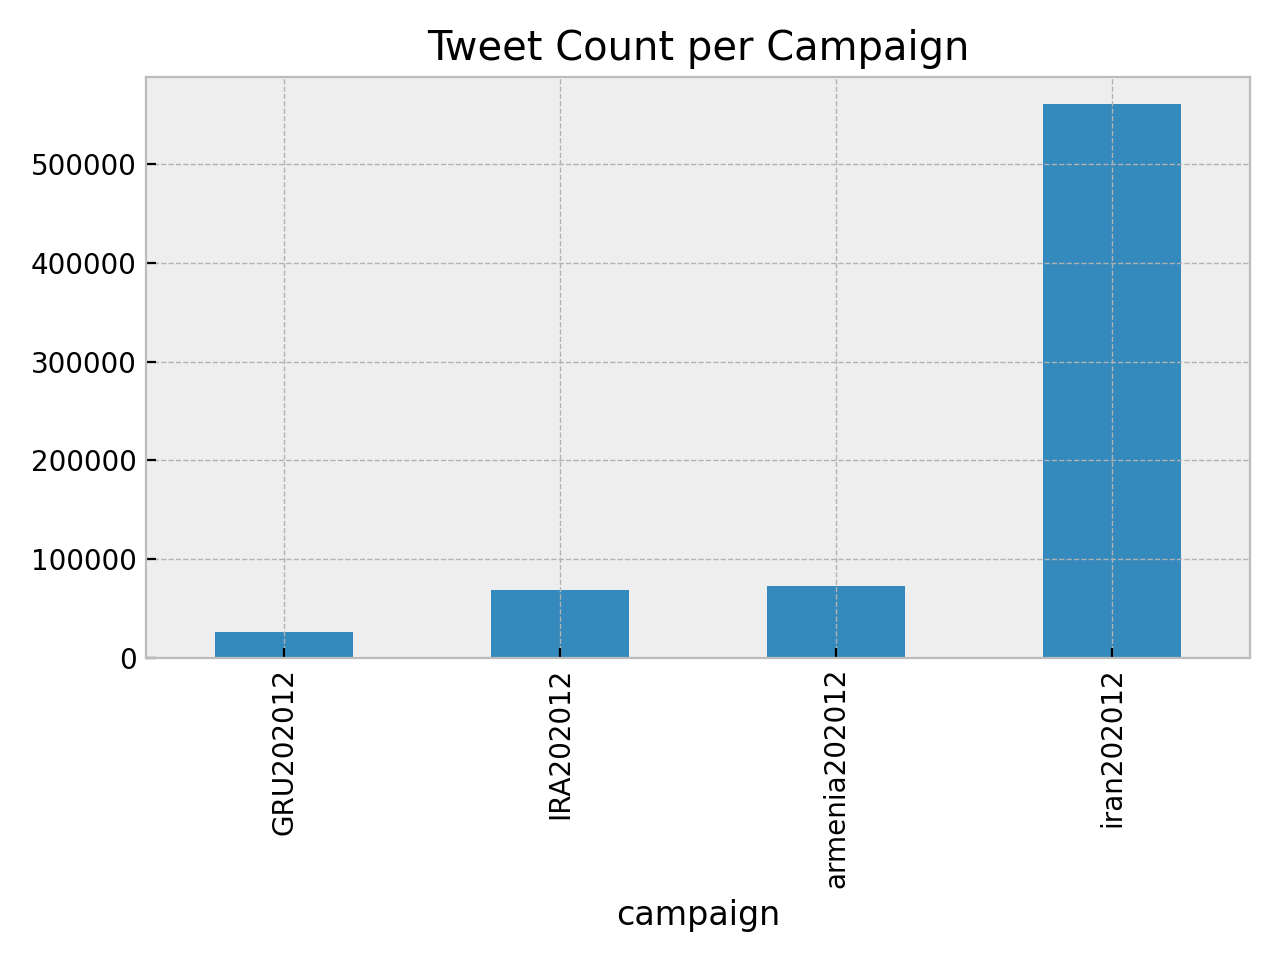

In [7]:
fig, ax = plt.subplots()

(tweets_df.groupby('campaign')
  .size()
).plot(ax=ax, kind='bar', title='Tweet Count per Campaign')

fig.tight_layout()
fig.show()

In [8]:
campaign = tweets_df.loc[:][tweets_df['campaign'] =='iran202012']
campaign_users = user_df.loc[:][user_df['campaign'] =='iran202012']

print('Campaign-identified users: {}'.format(len(campaign_users)))

start = (campaign
         .loc[:]['tweet_time']
         .min()
)
end = (campaign
         .loc[:]['tweet_time']
         .max()
)
print('Campaign duration: {}'.format(end - start))

Campaign-identified users: 238
Campaign duration: 4130 days 04:12:00


In [9]:
active_index = campaign_users.index.isin(campaign['userid'])
active_campaign_users = campaign_users[active_index]
inactive_campaign_users = campaign_users[~active_index]

ans = 'Active campaign accounts: {}'.format(len(active_campaign_users))
print(ans)

ans = 'Inactive campaign accounts: {}'.format(len(inactive_campaign_users))
print(ans)

ans = 'Total campaign accounts: {}'.format(len(campaign_users.index))
print(ans)

Active campaign accounts: 209
Inactive campaign accounts: 29
Total campaign accounts: 238


In [10]:
print('Total tweets: {}'.format(len(campaign)))
print('Tweets per user:')
tweets_per_user = (campaign
                .groupby('userid')
                .size()
                .describe()
                .astype('int')
)[['mean','std','min','max']]
print(tweets_per_user)
print('Tweets from max user: {:.2%}'
      .format(tweets_per_user.loc['max'] / len(campaign)))

Total tweets: 560571
Tweets per user:
mean      2682
std      21022
min          1
max     302648
dtype: int64
Tweets from max user: 53.99%


In [11]:
max_user = (campaign
           .groupby('userid')
           .size()
           .idxmax()
           )
print('Max user: {}'.format(max_user))

Max user: 213589457


Interestingly, the top-tweeting user for the Iran campaign is a Spanish-language account, with a user-reported location of Teheran.

In [12]:
print(campaign_users.loc[max_user])

user_display_name                                                    HispanTV
user_screen_name                                                     Hispantv
user_reported_location                                                Teherán
user_profile_description    Medio no corporativo, que se hace eco de las r...
user_profile_url                                       http://t.co/SU1GJqdDNM
follower_count                                                         161512
following_count                                                            31
account_creation_date                                     2010-11-09 00:00:00
account_language                                                           es
file                        hashed_2020_12_iran_202012_iran_202012_users_c...
campaign                                                           iran202012
release                                                                202012
government                                                      

In [13]:
print(campaign
.groupby('userid')
.get_group(max_user)
.groupby(['latitude', 'longitude'])
.size()
)

latitude  longitude
absent    absent       302648
          present           0
present   absent            0
          present           0
dtype: int64


In [14]:
print('Tweet counts per user')
tweet_counts_per_user = (campaign
                        .groupby('userid')
                        .size()
                       )
print(tweet_counts_per_user.sort_values(ascending=False))

Tweet counts per user
userid
213589457                                       302648
T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=      18851
etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=     14115
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=     13304
1067814896706994176                              12790
                                                 ...  
Q1Gccf8mIb7MdLjvb7eKThktteoMMAIeTAfo+HbjtWc=         1
xRguKYrfYy7pBmb6LzrFQw9XUmjThHyA+WSFqP7u5E=          1
OiGJvJyTyR77VscoQBz5HEs8pfB+Npnmhfd1CIVx0As=         1
O2v43Q2piVdfKPC6mJtJmo4O0JBPtMG2F4CucMA3FA=          1
zk4khaX7A3XhXVndteeiXLe4ma8xR7bYMBCOhCt68j8=         1
Length: 209, dtype: int64


<IPython.core.display.Javascript object>


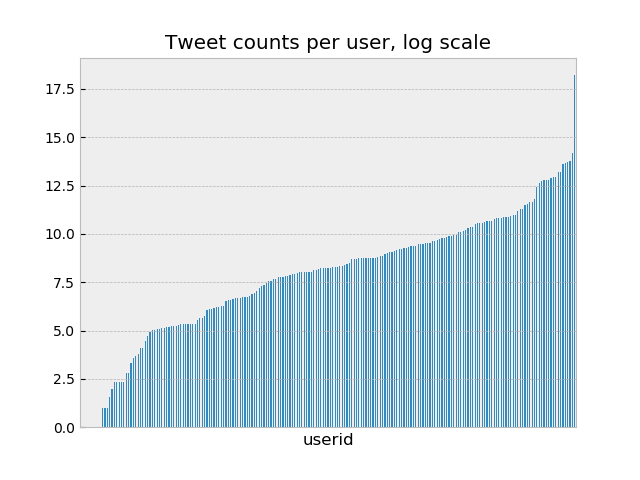

In [16]:
fig, ax = plt.subplots()

(np.log2(tweet_counts_per_user
 .sort_values()
).plot(ax=ax, kind='bar', xticks=([]), title='Tweet counts per user, log scale'))

fig.show()

In [18]:
print('Like counts per user:')
like_counts_per_user = (campaign
                        .groupby('userid')
                        .sum()
                        .loc[:]['like_count']
                       )
like_counts_per_user.sort_values(ascending=False)

Like counts per user:


userid
213589457                                       1799708
DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=     179460
PpOfb+YOWXe3t9rDg7EJ55neK4hKxdNioiA91GAANs=       97741
1099221870530961408                               87908
1091795789263921152                               64480
                                                 ...   
aJdvwfdmprSTKVP0S4dQmEQ3nT5qVnRyYyIdXnYOdyo=          0
djt7FLKLI76zIdPZHvdLNKMth8pEH8+zHauTj5wBc8=           0
BAszjp3oepGsQa6QkPdEbzGMOFLIUxZpwR7JP7NGL8=           0
iBo2Ov46z4inKNY4kNAWbcTtVUSDdEjZkwTBJdpQ5bk=          0
zk4khaX7A3XhXVndteeiXLe4ma8xR7bYMBCOhCt68j8=          0
Name: like_count, Length: 209, dtype: int64

In [20]:
print((like_counts_per_user
 .describe()
 .astype('int')
)[['mean','std','min','max']])

mean      13928
std      125374
min           0
max     1799708
Name: like_count, dtype: int64


<IPython.core.display.Javascript object>


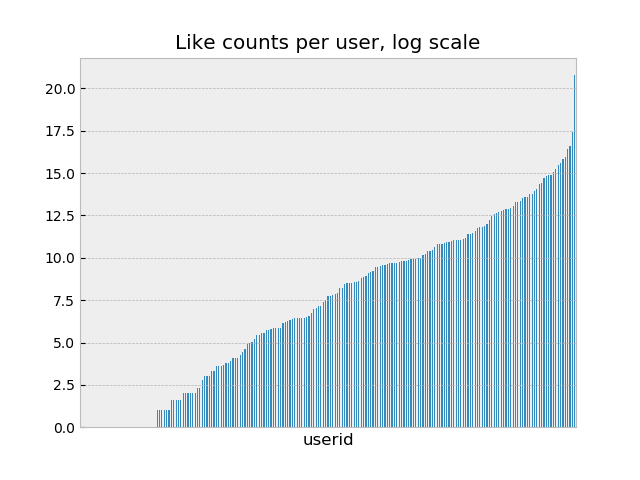

/home/sarah/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
fig, ax = plt.subplots()

(np.log2(like_counts_per_user
 .sort_values()
).plot(kind='bar', xticks=([]), title='Like counts per user, log scale'))

fig.show()

In [25]:
most_liked_tweet = campaign['like_count'].idxmax()
print('"',campaign
 .loc[most_liked_tweet]['tweet_text'],
      '"'
)
print('\nNumber of likes: {}'.format(campaign['like_count'].max()))

" I lived with Kavanaugh at Yale.The FBI never returned my call.

Many were in the same place; they tried to get in contact with FBI, with no luck. Now GOP senators are claiming FBI report showed 'nothing they didn't already know'. Bullshit
https://t.co/aIDK2IZ7ek 

#KavanaughLied "

Number of likes: 63863


In [27]:
print(campaign
 .loc[most_liked_tweet][fields]
)

like_count       63863
quote_count       1155
reply_count       1385
retweet_count    26269
Name: 1173315426039869441, dtype: object


In [28]:
most_liked_tweet_user = (campaign
            .loc[most_liked_tweet]['userid']
            )
campaign_users.loc[most_liked_tweet_user][:-4]

user_display_name                DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=
user_screen_name                 DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=
user_reported_location                                             California
user_profile_description    "No one fixes the world alone."\n\n#BlueWave #...
user_profile_url                                                         <NA>
follower_count                                                           2439
following_count                                                          1164
account_creation_date                                     2019-08-18 00:00:00
account_language                                                           en
Name: DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=, dtype: object

In [29]:
(campaign
.groupby('userid')
.get_group(most_liked_tweet_user)
.loc[:]['tweet_text']
)

tweetid
1229755066690809857    Kaitlin Bennett was welcomed by Ohio Universit...
1246761172256382976    I'm not religious &amp; certainly not Christia...
1237383479249252352    Top pro-Warren group endorses Bernie ahead of ...
1238585046371573760    Trump won’t test for #coronavirus despite soci...
1190991490551615488    "after years of horrifying footage of people w...
                                             ...                        
1194220460877197314             @realDonaldTrump https://t.co/m4hxfoFxwt
1261636552461029384    @realDonaldTrump @LisaMarieBoothe @ffweekend “...
1224724777610420224    @realDonaldTrump Your Approval Rating accordin...
1186604356809953281    @realDonaldTrump @kilmeade @foxandfriends Late...
1194608947359031296      @realDonaldTrump WE did https://t.co/2rJXFd4PrI
Name: tweet_text, Length: 1937, dtype: string

Considering this most-liked tweet has an order of magnitude more likes than the next most-liked tweet, we could exclude this outlier in our analyses for a more accurate description of the campaign tweet distributions overall.

## Unique Users

In [31]:
userids = dict(get_unique_ids(campaign, campaign_users))
print('Unique users:', len(userids))

Unique users: 61117


## Interactions

The standard deviations of count measures are considerably smaller after removing the most-liked tweet:

In [38]:
with_outlier = (campaign
               .describe()
              )
without_outlier = (campaign
                .drop(index=most_liked_tweet)
                .describe()
               )
print('with outlier user:\n',
  with_outlier
 .loc[stats][fields]
 .astype('int'),
 '\n\n'
)
print('without outlier user:\n',
  without_outlier
 .loc[stats][fields]
 .astype('int')
)

with outlier user:
       like_count  quote_count  reply_count  retweet_count
mean           5            0            0              5
std          105            3            5             47
min            0            0            0              0
max        63863         1155         2222          26269 


without outlier user:
       like_count  quote_count  reply_count  retweet_count
mean           5            0            0              5
std           61            2            5             32
min            0            0            0              0
max        18145         1109         2222           9967


The plot below gives some indication of the different scales of different types of tweet interactions.

<IPython.core.display.Javascript object>


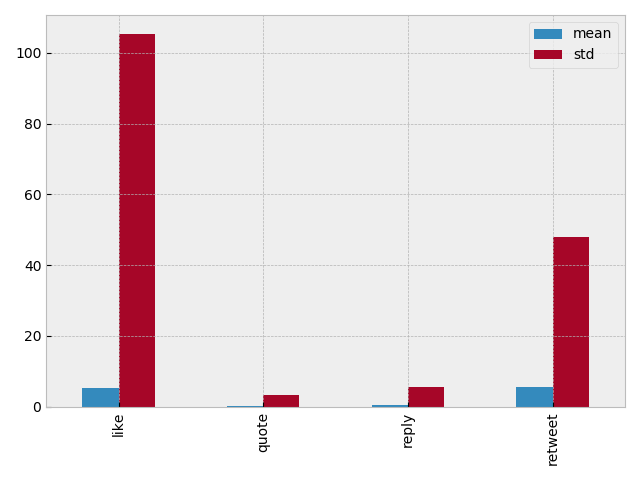

In [39]:
fig, ax = plt.subplots()

(campaign
 .describe()
 .T
 .loc[fields][plot_stats]
 .rename(index=dict(zip(fields, [re.sub('_count', '', field) for field in fields])))
).plot(ax=ax, kind='bar')

fig.tight_layout()
fig.show()

Aggregate counts per user:

In [41]:
print((campaign
    .groupby('userid')
    .sum()
    .loc[:][fields]
    .describe()
    .astype('int')
).loc[stats])

      like_count  quote_count  reply_count  retweet_count
mean       13928          644         1125          15008
std       125374         7383         8918         192315
min            0            0            0              0
max      1799708       106618       127521        2780592


## Original Tweets vs. Retweets

In [42]:
def original_tweets(tweets_df):
    is_retweet = tweets_df['is_retweet'] == False
    return (tweets_df
            .loc[:][is_retweet]
           )

def retweets(tweets_df):
    is_retweet = tweets_df['is_retweet'] == True
    return (tweets_df
            .loc[:][is_retweet]
           )

def replies(tweets_df):
    is_reply = tweets_df['in_reply_to_tweetid'].notna()
    return (tweets_df
            .loc[:][is_reply]
           )

In [45]:
print('Original tweet count: {}'.format(len(original_tweets(campaign))))
print('Retweet count: {}'.format(len(retweets(campaign))))
print('Reply count: {}'.format(len(replies(campaign))))
print('\n')
print('Campaign original tweet percent: {:.2%}'
      .format(len(original_tweets(campaign)) / len(campaign)))
print('Campaign retweet percent: {:.2%}'
      .format(len(retweets(campaign)) / len(campaign)))
print('Campaign reply percent: {:.2%}'
      .format(len(replies(campaign)) / len(campaign)))

Original tweet count: 460125
Retweet count: 100446
Reply count: 89139


Campaign original tweet percent: 82.08%
Campaign retweet percent: 17.92%
Campaign reply percent: 15.90%


<IPython.core.display.Javascript object>


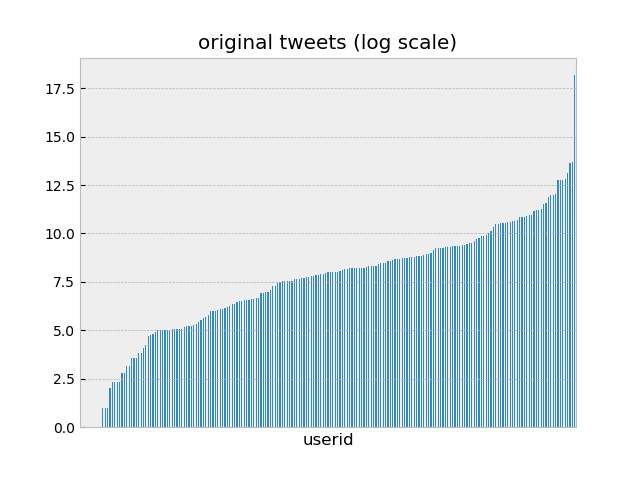

In [47]:
fig, ax = plt.subplots()

np.log2(original_tweets(campaign)
 .groupby('userid')
 .size()
 .sort_values()
).plot(ax=ax, kind='bar',xticks=([]), title='original tweets (log scale)')

fig.show()

<IPython.core.display.Javascript object>


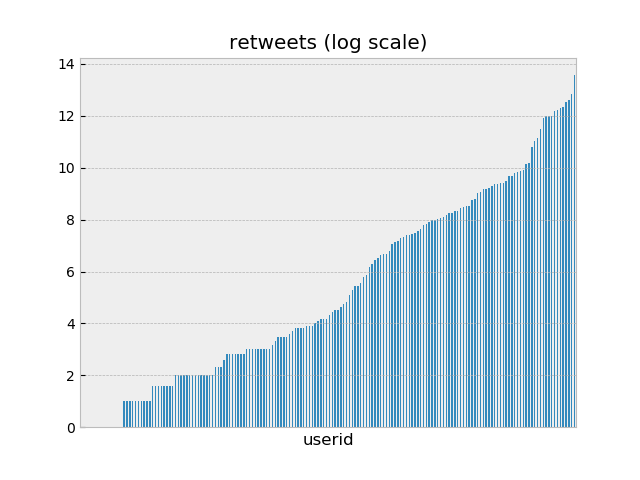

In [48]:
fig, ax = plt.subplots()

np.log2(retweets(campaign)
 .groupby('userid')
 .size()
 .sort_values()
).plot(ax=ax, kind='bar',xticks=([]), title='retweets (log scale)')

fig.show()

In [50]:
most_tweeting_users = (campaign
                      .groupby('userid')
                      .size()
                      .sort_values(ascending=False)
                      ).head(10)

top_users_rt = (campaign
                .pipe(retweets)
                .groupby('userid')
                .size()
               ).loc[most_tweeting_users.index]
print(top_users_rt)

userid
213589457                                        7336
T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=      6241
etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=     5227
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=       17
1067814896706994176                              5960
1235289416370774016                             12143
rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=       5078
WFMM2eW8YAMex3B1z4P8vxx0OvkEJvFCx9l0uYGMqug=     2072
ihPCMQ32xEzpD35Et9IH4HO21XKiWdSJreVg+pHT5o=      3859
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=      4076
dtype: int64


<IPython.core.display.Javascript object>


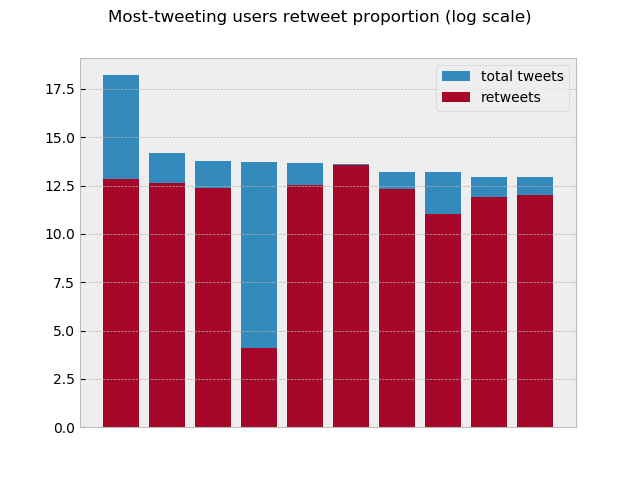

In [51]:
fig, ax = plt.subplots()
ax.bar(most_tweeting_users.index, np.log2(most_tweeting_users), label='total tweets')
ax.bar(most_tweeting_users.index, np.log2(top_users_rt), label='retweets')
ax.set_xticks([])
ax.legend()
fig.suptitle('Most-tweeting users retweet proportion (log scale)')
fig.show()

In [53]:
(original_tweets(campaign)
 .describe()
).loc[stats][fields]

,like_count,quote_count,reply_count,retweet_count
mean,6.33,0.29,0.51,6.82
std,116.32,3.52,6.10,52.80
min,0.00,0.00,0.00,0.00
max,63863.00,1155.00,2222.00,26269.00


In [54]:
(retweets(campaign)
 .describe()
).loc[stats][fields]

,like_count,quote_count,reply_count,retweet_count
mean,0.00,0.00,0.00,0.00
std,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00
max,0.00,0.00,0.00,0.00


We see here that for this campaign we apparently do not have reaction count data for retweets, indicating that we may need to treat those values as missing when considering reaction statistics for the dataset overall.

## User connections

In [55]:
# retweets between users identified with the campaign
inside_rt = campaign[campaign['retweet_userid']
                     .isin(campaign_users.index)]
(inside_rt
 .groupby(['userid','retweet_userid'])
 .size()
)

userid                                        retweet_userid                              
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=  0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=     25
                                              1099221870530961408                               3
                                              HcrkAj2Z5laESkAd3aQjE1dgoP6r9xDN6LLzEIHzX4=       6
                                              Llwo+0XebgvqnGE1UiwiaJqfQWQF6NJX+gnV77DBRpk=      4
                                              M4AN5Ed68gBwmVS3DcPbwuXv7cJRYDwsCvmJ84BYSB0=      3
                                                                                             ... 
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=   mpY+AZI80Nu61VS3o4Zm+UXTjaxrkE08xU0nO3JQ=        18
                                              rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=       77
                                              tfIRka6bXJoCm84UisMb2m4L8XpKyPJr7Yfv8UmeQ=        2
                           

In [56]:
# replies between users identified with the campaign
inside_re = campaign[campaign['in_reply_to_userid']
                     .isin(campaign_users.index)]
(inside_re
 .groupby(['userid','in_reply_to_userid'])
 .size()
)

userid                                        in_reply_to_userid                          
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=  0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=      19
1067814896706994176                           79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=       2
                                              BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=        11
                                              Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=        1
                                              etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=      77
                                                                                              ... 
xkCWfX+FKOlOHNYjW1jeAG4IfrkxhOZLVbgnDWHVevg=  xkCWfX+FKOlOHNYjW1jeAG4IfrkxhOZLVbgnDWHVevg=      29
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=   HcrkAj2Z5laESkAd3aQjE1dgoP6r9xDN6LLzEIHzX4=        1
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=   Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=       22
                  

## Misc

In [57]:
(campaign
 .groupby('userid')
 .get_group(max_user)['tweet_language']
).value_counts()[:15]

es     185034
und       843
pt        666
ca        275
en        111
ro         79
it         66
sl         44
hu         43
fr         42
in         24
cy         23
tl         21
tr         10
ht          9
Name: tweet_language, dtype: Int64

In [58]:
max_user_tweets = (campaign
 .groupby('userid')
 .get_group(max_user)
)

(max_user_tweets 
.query('tweet_language != "es"')
)['tweet_text']

tweetid
176529391885619201    ¡Quedan 3 episodios para el final!
Serie "El p...
246981262789709826    Nicaragua, país más seguro de Centroamérica ht...
233634440843243520    Competencia entre militares israelíes para mat...
149698768441327616    Construcción de la empresa Nacional iraní de I...
72108820268195840     Rusia, Polonia y Alemania discuten relaciones ...
                                            ...                        
268298939176976384    I uploaded a @YouTube video http://t.co/4klILC...
264831762440531968    I uploaded a @YouTube video http://t.co/KZo1cC...
492029494153052161    Piden eliminar programas de deportación en EEU...
544193600033013760    Voto extranjero en Francia espera la decisión ...
243819549844193280    I uploaded a @YouTube video http://t.co/FYbeBl...
Name: tweet_text, Length: 117614, dtype: string

In [59]:
(campaign_users
 .loc[max_user]['account_language']
)

'es'

In [60]:
(campaign_users
 .loc[:]['user_reported_location']
 .unique()
)

<StringArray>
[                            <NA>,                      'Worldwide',
              'Brooklyn New York',                           'مشهد',
                          'Paris',                      'Indonesia',
                       'New York',             'Caracas, Venezuela',
                     'NEW JERSEY',                      'Venezuela',
                     'California',                    'Los Angeles',
                          'Earth',                  'IN A DILEMMA ',
         'Minnesota, Minneapolis',                'California, USA',
            'Heidelberg, Germany',                           'iran',
                         'PERSIA',                         'Oregon',
    'The city between two rivers',                 'World Citizen ',
                    'en el mundo', 'زیر باران کنار تنهایی قدم زنان',
                    'California ',                       'Chicago ',
                         'long i',                      'Tampa, FL',
   'Jakarta Selatan,

In [61]:
(campaign
 .loc[:]['account_language']
 .unique()
)

<StringArray>
['fr', 'en', 'fa', 'id', 'en-gb', 'es']
Length: 6, dtype: string

In [62]:
(campaign
 .loc[:]['tweet_language']
 .unique()
)

<StringArray>
[ 'fr',  'en',  <NA>,  'in',  'es',  'fa',  'ar', 'und',  'ca',  'tl',  'pt',
  'th',  'da',  'fi',  'lt',  'tr',  'cs',  'cy',  'et',  'hi',  'ro',  'de',
  'id',  'it',  'iw',  'sv',  'bn',  'nl',  'lv',  'no',  'ur',  'pl',  'eu',
  'ht',  'hu',  'sl',  'vi',  'hr',  'sd',  'zh',  'ru',  'ja',  'is',  'ko',
  'bs',  'sk',  'uk']
Length: 47, dtype: string